In [1]:
import pandas as pd
import yaml
import os
import time
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.ensemble import  RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# data is taken from Cricsheets.org website. The data is in .yaml files for each match and coverted to csv files
overall_batsman_details  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cricket_dataset/overall_batsman_details.csv')
overall_bowler_details = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cricket_dataset/overall_bowler_details.csv')
match_batsman_details = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cricket_dataset/match_batsman_details.csv')
match_bowler_details = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cricket_dataset/match_bowler_details.csv')

In [3]:
overall_bowler_details.head()

,player_name,team,innings,runs,balls,wickets,extras,average,strike_rate,economy,wicket_hauls
0,DAJ Bracewell,New Zealand,17,729,869,21,24,32.198484,40.157252,5.033482,1
1,MJ Henry,New Zealand,46,2316,2590,86,120,26.902224,29.702324,5.367408,8
2,MJ McClenaghan,New Zealand,45,2350,2439,92,150,24.219702,25.657518,5.771338,10
3,MJ Santner,New Zealand,54,2159,2631,61,71,27.837449,34.188382,4.919305,1
4,IS Sodhi,New Zealand,25,1143,1263,33,32,26.683407,30.533725,5.491139,2


In [4]:
overall_batsman_details.head()

,player_name,team,innings,runs,balls,average,strike_rate,centuries,fifties,zeros
0,MD Gunathilaka,Sri Lanka,29,1115,1321,38.448276,78.123501,2,8,1
1,TM Dilshan,Sri Lanka,234,8646,10076,36.948718,81.745739,21,39,8
2,HDRL Thirimanne,Sri Lanka,95,2834,3934,29.831579,65.267925,4,17,5
3,LD Chandimal,Sri Lanka,116,3100,4255,26.724138,65.611057,3,21,10
4,AD Mathews,Sri Lanka,167,5046,6067,30.215569,75.520432,2,35,15


In [5]:
match_batsman_details.head()

,date,name,team,opposition,venue,innings_played,previous_average,previous_strike_rate,previous_centuries,previous_fifties,previous_zeros,runs
0,2015-12-28,MD Gunathilaka,Sri Lanka,New Zealand,Hagley Oval,0,0.0,0.0,0,0,0,17
1,2015-12-28,TM Dilshan,Sri Lanka,New Zealand,Hagley Oval,0,0.0,0.0,0,0,0,7
2,2015-12-28,HDRL Thirimanne,Sri Lanka,New Zealand,Hagley Oval,0,0.0,0.0,0,0,0,1
3,2015-12-28,LD Chandimal,Sri Lanka,New Zealand,Hagley Oval,0,0.0,0.0,0,0,0,9
4,2015-12-28,AD Mathews,Sri Lanka,New Zealand,Hagley Oval,0,0.0,0.0,0,0,0,17


In [6]:
match_bowler_details.head()

,date,name,team,opposition,venue,innings_played,previous_average,previous_strike_rate,previous_economy,previous_wicket_hauls,wickets
0,2015-12-28,DAJ Bracewell,New Zealand,Sri Lanka,Hagley Oval,0,0.0,0.0,0.0,0,1
1,NaN,MJ Henry,New Zealand,Sri Lanka,Hagley Oval,0,0.0,0.0,0.0,0,4
2,NaN,MJ McClenaghan,New Zealand,Sri Lanka,Hagley Oval,0,0.0,0.0,0.0,0,4
3,NaN,MJ Santner,New Zealand,Sri Lanka,Hagley Oval,0,0.0,0.0,0.0,0,0
4,NaN,IS Sodhi,New Zealand,Sri Lanka,Hagley Oval,0,0.0,0.0,0.0,0,1


In [7]:
print(match_batsman_details.shape)
print(match_bowler_details.shape)
print(overall_batsman_details.shape)
print(overall_bowler_details.shape)

(30161, 12)
(21048, 11)
(1566, 10)
(1196, 11)


In [8]:
overall_batsman_details.columns

Index(['player_name', 'team', 'innings', 'runs', 'balls', 'average',
       'strike_rate', 'centuries', 'fifties', 'zeros'],
      dtype='object')

Text(0.5, 1.0, 'Correlation matrix for over all batting')

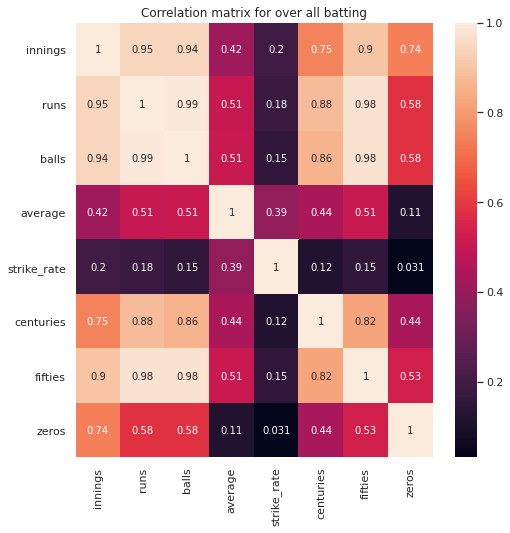

In [9]:
bat_column = ['innings', 'runs', 'balls', 'average', 'strike_rate', 'centuries', 'fifties', 'zeros']
bowl_column = ['innings', 'runs', 'balls', 'wickets', 'extras',	'average',	'strike_rate',	'economy',	'wicket_hauls']

corr_bat = overall_batsman_details[bat_column].corr()
plt.figure(figsize=(8, 8))
sns.set_style('whitegrid')
sns.heatmap(corr_bat,annot=True)
plt.title("Correlation matrix for over all batting")

Text(0.5, 1.0, 'Correlation matrix for over all bowler')

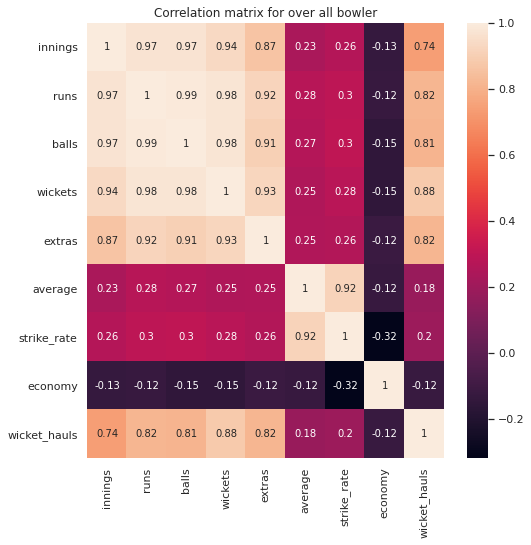

In [10]:
corr_bowl = overall_bowler_details[bowl_column].corr()

plt.figure(figsize=(8, 8))
sns.set_style('whitegrid')
sns.heatmap(corr_bowl, annot=True)
plt.title("Correlation matrix for over all bowler")

Text(0.5, 1.0, 'Top 5 maximum runs score by the batsman')

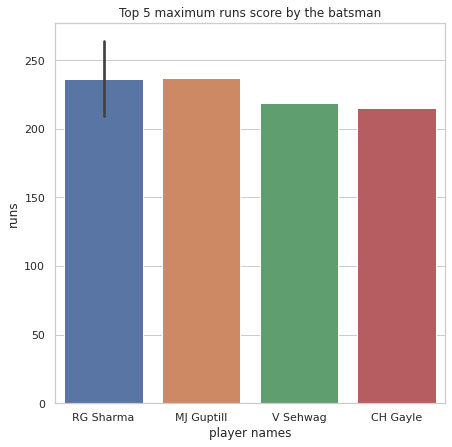

In [11]:
max_runs_by_batsman = match_batsman_details.nlargest(5, columns=['runs'])

plt.figure(figsize=(7, 7))
sns.set_style('whitegrid')
ax = sns.barplot(x = max_runs_by_batsman['name'], y = max_runs_by_batsman['runs'], data= max_runs_by_batsman)
plt.xlabel('player names')
plt.ylabel('runs')
plt.title("Top 5 maximum runs score by the batsman")

Text(0.5, 1.0, 'Top 5 maximum wickets taken by the bowler')

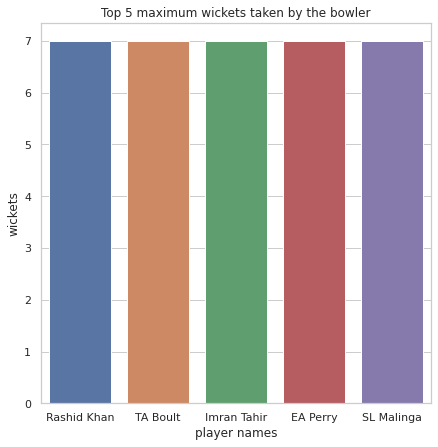

In [12]:
max_wickets_by_bowler = match_bowler_details.nlargest(5, columns=['wickets'])

plt.figure(figsize=(7, 7))
sns.set_style('whitegrid')
ax = sns.barplot(x = max_wickets_by_bowler['name'], y = max_wickets_by_bowler['wickets'], data= max_wickets_by_bowler)
plt.xlabel('player names')
plt.ylabel('wickets')
plt.title("Top 5 maximum wickets taken by the bowler")

In [13]:
# Help to return the best parameters

def girdsearchcv_result(results):
    arg, params, flag = None, None, None
    split0 = results['split0_test_score'].max()
    split1 = results['split1_test_score'].max()
    if (split0 >= split1):
        arg = results['split0_test_score'].argmax()
        flag = split0
    else:
        arg = results['split1_test_score'].argmax()
        flag = split1
    params = results['params'][arg]
    return flag, params

In [17]:
# Function return's the accuracy of the algorithm and the prdicted score

def player_performance(param, player_name, opposition=None, venue=None):
    res = {}
    score = []
    name = []
    if param == 1:
        match_batsman_details.loc[:, 'date'].ffill(inplace=True) #filling the empty values
        bat_match_details = match_batsman_details[match_batsman_details['name'] == player_name] # choose the selected player
        bat_match_details = bat_match_details[bat_match_details['opposition'] == opposition] # choose the oppostion of the player played
        bat_overall_details = overall_batsman_details[overall_batsman_details['player_name'] == player_name][['player_name', 'team', 'innings', 'runs', 'average', 'strike_rate', 'centuries', 'fifties', 'zeros']] # extract the data of the player
        bat_features = bat_match_details.loc[:, ['opposition', 'venue', 'innings_played', 'previous_average' , 'previous_strike_rate', 'previous_centuries', 'previous_fifties', 'previous_zeros']] # extract the features of the player
        bat_targets = bat_match_details.loc[:,['runs']] # outcome
    elif param == 2:
        match_bowler_details.loc[:,'date'].ffill(inplace = True) #filling the empty values
        bowl_match_details = match_bowler_details[match_bowler_details['name'] == player_name] # choose the selected player
        bowl_match_details = bowl_match_details[bowl_match_details['opposition'] == opposition] # choose the oppostion of the player played
        bowl_overall_details = overall_bowler_details[overall_bowler_details['player_name'] == player_name][['player_name','team','innings','wickets','average','strike_rate','economy','wicket_hauls']] # extract the data of the player
        bowl_features = bowl_match_details.loc[:,['opposition', 'venue', 'innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']] # extract the features of the player
        bowl_target = bowl_match_details.loc[:,['wickets']] # outcome
    elif param == 3:
        match_batsman_details.loc[:, 'date'].ffill(inplace=True) #filling the empty values
        bat_match_details = match_batsman_details[match_batsman_details['name'] == player_name] # choose the selected player
        bat_match_details = bat_match_details[bat_match_details['opposition'] == opposition] # choose the oppostion of the player played
        bat_overall_details = overall_batsman_details[overall_batsman_details['player_name'] == player_name][['player_name', 'team', 'innings', 'runs', 'average', 'strike_rate', 'centuries', 'fifties', 'zeros']] # extract the data of the player
        bat_features = bat_match_details.loc[:, ['opposition', 'venue', 'innings_played', 'previous_average' , 'previous_strike_rate', 'previous_centuries', 'previous_fifties', 'previous_zeros']] # extract the features of the player
        bat_targets = bat_match_details.loc[:,['runs']] # outcome

        match_bowler_details.loc[:,'date'].ffill(inplace = True)
        bowl_match_details = match_bowler_details[match_bowler_details['name'] == player_name]
        bowl_match_details = bowl_match_details[bowl_match_details['opposition'] == opposition]
        bowl_overall_details = overall_bowler_details[overall_bowler_details['player_name'] == player_name][['player_name','team','innings','wickets','average','strike_rate','economy','wicket_hauls']]
        bowl_features = bowl_match_details.loc[:,['opposition', 'venue', 'innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']]
        bowl_targets = bowl_match_details.loc[:,['wickets']]

    le = LabelEncoder() # used to encode the opposition and venue beacuase they are in string format
    sc = StandardScaler() 

    if (param == 1 or param == 3):

        bins = [0, 10, 30, 50, 80, 120, 250]
        labels = ["0", "1", "2", "3", "4", "5"]
        bat_targets = pd.cut(bat_targets['runs'], bins, labels=labels, include_lowest=True)

        classes_bat = len(bat_targets.unique())

        if classes_bat >= 2:
            le.fit(bat_features.loc[:,'opposition'])
            opp_bat = le.transform([opposition])
            bat_features.loc[:,'opposition'] = le.transform(bat_features.loc[:,'opposition'])
            le.fit(bat_features.loc[:,'venue'])
            ven_bat = le.transform([venue])
            bat_features.loc[:,'venue'] = le.transform(bat_features.loc[:,'venue'])

            predict_bat = bat_overall_details[['innings','average','strike_rate','centuries','fifties','zeros']].values[0]

            bat_means = bat_features.loc[:,['innings_played','previous_average','previous_strike_rate','previous_centuries','previous_fifties','previous_zeros']].mean() #mean score of the player
            bat_std = bat_features.loc[:,['innings_played','previous_average','previous_strike_rate','previous_centuries','previous_fifties','previous_zeros']].std() # std score of the player
            predict_bat = ((predict_bat-bat_means)/bat_std).tolist() 
            bat_features.loc[:,['innings_played','previous_average','previous_strike_rate','previous_centuries','previous_fifties','previous_zeros']] = sc.fit_transform(bat_features.loc[:,['innings_played','previous_average','previous_strike_rate','previous_centuries','previous_fifties','previous_zeros']])

            predict_bat.insert(0, ven_bat[0]) # insert the venue
            predict_bat.insert(0, opp_bat[0]) # insert the opposition

            bat_features = bat_features.values
            bat_targets = bat_targets.values
            predict_bat_features = np.array(predict_bat).reshape(-1,1)
            predict_bat_features = predict_bat_features.T
            predict_bat_features = np.nan_to_num(predict_bat_features) # covert the nan to numbers

            print('\n Batting Parameters Tuning begins')
            
            if classes_bat > 2:
                bat_xgb = XGBClassifier(objective='multi:softmax', verbosity=0, silent=True)  #uses the XGBClassifier if no of classes bat is greater than 2
            else:
                bat_xgb = XGBClassifier(objective='binary:logistic', verbosity=0, silent=True) #uses the XGBClassifier if no of classes bat is less than 2 with objective logistic
            bat_parameters_xgb = {'n_estimators': [75, 100, 125], 'learning_rate': [0.1, 0.01], 'booster': ['gbtree', 'dart']}

            if classes_bat > 2:
                bat_rfc = RandomForestClassifier(random_state=42) #uses the random forest
                bat_parameters_rfc = {'n_estimators': [75, 100, 125], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]}
            else:
                bat_rfc = RandomForestClassifier(random_state=42, min_samples_leaf=1)
                bat_parameters_rfc = {'n_estimators': [75, 100, 125], 'criterion': ['gini', 'entropy']}

            bat_svc = SVC() #uses the support vector classification SVC()
            bat_parameters_svc = {'C': [1, 5, 10], 'kernel': ['rbf','linear', 'sigmoid'], 'gamma': ['auto', 'scale']}
            bat_knn = KNeighborsClassifier() #uses the K neighbors Classifier
            bat_parameters_knn = {'n_neighbors': [1, 3], 'metric': ['euclidean', 'minkowski']}

            bat_best_score, bat_best_params = None, None

            #check for the best accuary amoung the all the above algorithm for the training data
            #XGBClassifier
            bat_girdsearch_xgb = GridSearchCV(estimator=bat_xgb, param_grid=bat_parameters_xgb, scoring='accuracy', cv=2)
            bat_girdresult_xgb = bat_girdsearch_xgb.fit(bat_features, bat_targets)
            bat_score, bat_params = girdsearchcv_result(bat_girdresult_xgb.cv_results_)
            bat_best_score, bat_params = [bat_score, 'xgb'], bat_params
            print("bat_score", bat_score , 'with classifier = XGB')
            score.append(bat_score*100)
            name.append('XGB')
            # Random forest
            bat_girdsearch_rfc = GridSearchCV(estimator=bat_rfc, param_grid=bat_parameters_rfc, scoring='accuracy', cv=2)
            bat_girdresult_rfc= bat_girdsearch_rfc.fit(bat_features, bat_targets)
            bat_score, bat_params = girdsearchcv_result(bat_girdresult_rfc.cv_results_)
            print("bat_score", bat_score , 'with classifier = Random forest')
            score.append(bat_score*100)
            name.append('Random forest')
            if bat_score > bat_best_score[0]:
                bat_best_score , bat_best_params = [bat_score, 'rfc'], bat_params
            #Support Vector Classifier
            bat_girdsearch_svc = GridSearchCV(estimator=bat_svc, param_grid=bat_parameters_svc, scoring='accuracy', cv=2)
            bat_girdresult_svc= bat_girdsearch_rfc.fit(bat_features, bat_targets)
            bat_score, bat_params = girdsearchcv_result(bat_girdresult_svc.cv_results_)
            print("bat_score", bat_score, 'with classifier = SVC' )
            score.append(bat_score*100)
            name.append('SVC')
            if bat_score > bat_best_score[0]:
                bat_best_score , bat_best_params = [bat_score, 'svc'], bat_params
            # KNeighbor
            bat_girdsearch_knn = GridSearchCV(estimator=bat_knn, param_grid=bat_parameters_knn, scoring='accuracy', cv=2)
            bat_girdresult_knn = bat_girdsearch_knn.fit(bat_features, bat_targets)
            bat_score, bat_params = girdsearchcv_result(bat_girdresult_knn.cv_results_)
            print("bat_score", bat_score, 'with classifier = KNN')
            score.append(bat_score*100)
            name.append('KNN')
            if bat_score > bat_best_score[0]:
                bat_best_score, bat_best_params = [bat_score, 'knn'], bat_params

            print(f'Batting Prediction accuracy={bat_best_score[0]} with classifier={bat_best_score[1].upper()}')

            print("Batting Prediction begin")
            #start predicting for the required data by the best accuracy algorithm
            #XGBClassifier
            if bat_best_score[1] == 'xgb':
                if classes_bat > 2:
                    bat_classifier = XGBClassifier(objective='multi:softmax',n_estimators=bat_best_params['n_estimators'],learning_rate=bat_best_params['learning_rate'],booster=bat_best_params['booster'],verbosity=0,silent=True)
                else:
                    bat_classifier = XGBClassifier(objective='binary:logistic',min_leaf_samples=1,n_estimators=bat_best_params['n_estimators'], learning_rate=bat_best_params['learning_rate'], booster=bat_best_params['booster'], verbosity=0, silent=True)
                bat_classifier = bat_classifier.fit(bat_features, bat_targets)
                res['bat_prediction'] = bat_classifier.predict(predict_bat_features)
            #RandomForestClassifier
            elif bat_best_score[1] == 'rfc':
                if classes_bat > 2:
                    bat_classifier = RandomForestClassifier(n_estimators=bat_best_params['n_estimators'],criterion=bat_best_params['criterion'],random_state=42,min_samples_leaf=bat_best_params['min_samples_leaf'])
                else:
                    bat_classifier = RandomForestClassifier(n_estimators=bat_best_params['n_estimators'],criterion=bat_best_params['criterion'],random_state=42,min_samples_leaf=1)
                bat_classifier = bat_classifier.fit(bat_features, bat_targets)
                res['bat_prediction'] = bat_classifier.predict(predict_bat_features)
                #SupportVectorMachine
            elif bat_best_score[1] == 'svc':
                bat_classifier = SVC(C=bat_best_params['C'],kernel=bat_best_params['kernel'],gamma=bat_best_params['gamma'])
                bat_classifier = bat_classifier.fit(bat_features,bat_targets)
                res['bat_prediction'] = bat_classifier.predict(predict_bat_features)
            #KNeighborsClassifier
            elif bat_best_score[1] == 'knn':
                bat_classifier = KNeighborsClassifier(n_neighbors=bat_best_params['n_neighbors'], metric=bat_best_params['metric'])
                bat_classifier = bat_classifier.fit(bat_features, bat_targets)
                res['bat_prediction'] = bat_classifier.predict(predict_bat_features)
            bat_runs = {'0':'0-10','1':'11-30','2':'31-50','3':'51-80','4':'81-120','5':'121-250'}
            res['bat_prediction'] = bat_runs[res['bat_prediction'][0]]

            print("Batting prediction completed")
        else:
            print('No Batting prediction')
    else:
        print('No Batting prediction')
    #simliar process will takes place in the bowl prediciton as well
    if (param == 2 or param == 3):

        bins = [0, 1, 3, 5, 7, 10, 11]
        labels = ['0', '1',  '2', '3', '4', '5']
        bowl_targets = pd.cut(bowl_targets['wickets'], bins, right=False, labels=labels, include_lowest=True )

        classes_bowl = len(bowl_targets.unique())

        if classes_bowl >= 2:

            le.fit(bowl_features['opposition'])
            opp_bowl = le.transform([opposition])
            bowl_features['opposition'] = le.transform(bowl_features['opposition'])
            le.fit(bowl_features['venue'])
            venue_bowl = le.transform([venue])
            bowl_features['venue'] = le.transform(bowl_features['venue'])

            predict_bowl = bowl_overall_details[['innings','average','strike_rate','economy','wicket_hauls']].values[0]

            bowl_means = bowl_features.loc[:,['innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']].mean()
            bowl_std= bowl_features.loc[:,['innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']].std()
            predict_bowl = ((predict_bowl-bowl_means)/bowl_std).tolist()
            bowl_features.loc[:,['innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']] = sc.fit_transform(bowl_features.loc[:,['innings_played','previous_average', 'previous_strike_rate', 'previous_economy','previous_wicket_hauls']])

            predict_bowl.insert(0, venue_bowl[0])
            predict_bowl.insert(0, opp_bowl[0])

            bowl_features = bowl_features.values
            bowl_targets = bowl_targets.values
            predict_bowl_features = np.array(predict_bowl).reshape(-1, 1)
            predict_bowl_features = predict_bowl_features.T
            predict_bowl_features = np.nan_to_num(predict_bowl_features)

            print('\nBowling Parameter Tuning begins...')
            #XGBClassifier
            if classes_bowl > 2:
                bowl_xgb = XGBClassifier(objective='multi:softmax', verbosity=0, silent=True)
            else:
                bowl_xgb = XGBClassifier(objective='binary:logistic',min_leaf_samples=1, verbosity=0, silent=True)
            bowl_parameters_xgb = {'n_estimators': [75, 100, 125], 'learning_rate': [0.1, 0.01], 'booster': ['gbtree', 'dart']}
            
            #RandomForestClassifier
            if classes_bowl > 2:
                bowl_rfc = RandomForestClassifier(random_state=42)
                bowl_parameters_rfc = {'n_estimators': [75, 100, 125], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]}
            else:
                bowl_rfc = RandomForestClassifier(random_state=42, min_samples_leaf=1)
                bowl_parameters_rfc = {'n_estimators': [75, 100, 125], 'criterion': ['gini', 'entropy']}
            #SupportVectorMachine
            bowl_svc = SVC()
            bowl_parameters_svc = {'C': [1, 5, 10], 'kernel': ['rbf','linear', 'sigmoid'], 'gamma': ['auto', 'scale']}
            #KNeighborsClassifier
            bowl_knn = KNeighborsClassifier()
            bowl_parameters_knn = {'n_neighbors': [1], 'metric': ['euclidean', 'minkowski']}

            bowl_best_score, bowl_best_params = None, None
            #XGBClassifier
            bowl_girdsearch_xgb = GridSearchCV(estimator=bowl_xgb, param_grid=bowl_parameters_xgb, scoring='accuracy', cv=2)
            bowl_girdresult_xgb = bowl_girdsearch_xgb.fit(bowl_features, bowl_targets)
            bowl_score, bowl_params = girdsearchcv_result(bowl_girdresult_xgb.cv_results_)
            bowl_best_score, bowl_best_params = [bowl_score, 'xgb'], bowl_params
            print("bowl_score", bowl_score, 'with classifier = XGB')
            #RandomForestClassifier
            bowl_girdsearch_rfc = GridSearchCV(estimator=bowl_rfc, param_grid=bowl_parameters_rfc, scoring='accuracy', cv=2)
            bowl_girdresult_rfc= bowl_girdsearch_rfc.fit(bowl_features, bowl_targets)
            bowl_score, bowl_params = girdsearchcv_result(bowl_girdresult_rfc.cv_results_)
            print("bowl_score", bowl_score, 'with classifier = Random forest')
            if bowl_score > bowl_best_score[0]:
                bowl_best_score , bowl_best_params = [bowl_score, 'rfc'], bowl_params
            #SupportVectorMachine
            bowl_girdsearch_svc = GridSearchCV(estimator=bowl_svc, param_grid=bowl_parameters_svc, scoring='accuracy', cv=2)
            bowl_girdresult_svc= bowl_girdsearch_rfc.fit(bowl_features, bowl_targets)
            bowl_score, bowl_params = girdsearchcv_result(bowl_girdresult_svc.cv_results_)
            print("bowl_score", bowl_score, 'with classifier= SVC')
            if bowl_score > bowl_best_score[0]:
                bowl_best_score , bowl_best_params = [bowl_score, 'svc'], bowl_params
            #KNeighborsClassifier
            bowl_girdsearch_knn = GridSearchCV(estimator=bowl_knn, param_grid=bowl_parameters_knn, scoring='accuracy', cv=2)
            bowl_girdresult_knn = bowl_girdsearch_knn.fit(bowl_features, bowl_targets)
            bowl_score, bowl_params = girdsearchcv_result(bowl_girdresult_knn.cv_results_)
            print("bowl_score", bowl_score, 'with classifier= KNN')
            if bowl_score > bowl_best_score[0]:
                bowl_best_score, bowl_best_params = [bowl_score, 'knn'], bowl_params

            print(f'Bowling Prediction accuracy={bowl_best_score[0]} with classifier={bowl_best_score[1].upper()}')

            print("Bowling Prediction begin")
            #XGBClassifier
            if bowl_best_score[1] == 'xgb':
                if classes_bowl > 2:
                    bowl_classifier = XGBClassifier(objective='multi:softmax',n_estimators=bowl_best_params['n_estimators'],learning_rate=bowl_best_params['learning_rate'],booster=bowl_best_params['booster'],verbosity=0,silent=True)
                else:
                    bowl_classifier = XGBClassifier(objective='binary:logistic', min_leaf_samples=1,n_estimators=bowl_best_params['n_estimators'], learning_rate=bowl_best_params['learning_rate'], booster=bowl_best_params['booster'], verbosity=0, silent=True)
                bowl_classifier = bowl_classifier.fit(bowl_features, bowl_targets)
                res['bowl_prediction'] = bowl_classifier.predict(predict_bowl_features)
            #RandomForestClassifier
            elif bowl_best_score[1] == 'rfc':
                if classes_bowl > 2:
                    bowl_classifier = RandomForestClassifier(n_estimators=bowl_best_params['n_estimators'],criterion=bowl_best_params['criterion'],random_state=42,min_samples_leaf=bowl_best_params['min_samples_leaf'])
                else:
                    bowl_classifier = RandomForestClassifier(n_estimators=bowl_best_params['n_estimators'],criterion=bowl_best_params['criterion'],random_state=42,min_samples_leaf=1)
                bowl_classifier = bowl_classifier.fit(bowl_features, bowl_targets)
                res['bowl_prediction'] = bowl_classifier.predict(predict_bowl_features)
            #SupportVectorMachine
            elif bowl_best_score[1] == 'svc':
                bowl_classifier = SVC(C=bowl_best_params['C'],kernel=bowl_best_params['kernel'],gamma=bowl_best_params['gamma'])
                bowl_classifier = bowl_classifier.fit(bowl_features,bowl_targets)
                res['bowl_prediction'] = bowl_classifier.predict(predict_bowl_features)
            #KNeighborsClassifier
            elif bowl_best_score[1] == 'knn':
                bowl_classifier = KNeighborsClassifier(n_neighbors=bowl_best_params['n_neighbors'], metric=bowl_best_params['metric'])
                bowl_classifier = bowl_classifier.fit(bowl_features, bowl_targets)
                res['bat_prediction'] = bowl_classifier.predict(predict_bowl_features)
            bowl_wickets = {'0':'0','1':'1-2','2':'3-4','3':'5-6','4':'7-9','5':'10'}
            res['bowl_prediction'] = bowl_wickets[res['bowl_prediction'][0]]

            print("Bowling prediction completed")
        else:
            print('No Bowling prediction')
    else:
        print('No Bowling prediction')


    return res

In [18]:
def input_values(input_value, check_list_1=None, check_list_2=None):
    if check_list_1 != None:
        if check_list_2 != None:
            print_list = sorted(set(check_list_1) & set(check_list_2))
            print(f'\nAvailable {input_value} : ',*print_list, sep='"\t"')
        else:
            print(f'\nAvailable {input_value} : ',*check_list_1, sep='"\t"')
    else:
        if check_list_2 != None:
            print(f'\nAvailable {input_value} : ',*check_list_1, sep='"\t"')
        else:
            pass
    
    while True:
        flag = 0
        res = input(f'\n Enter thr desired {input_value}: ')
        if check_list_1 != None:
            if res in check_list_1:
                flag += 1
        if check_list_2 != None:
            if res in check_list_2:
                flag += 2
        if flag>0:
            return res, flag
        else:
            print('invalid input')
            continue

In [20]:
# take the user input
team,dump = input_values('team', match_batsman_details['team'].unique().tolist())
print(dump,team)

player_name, param_player = input_values('player_name', sorted(match_batsman_details[match_batsman_details['team'] == team]['name'].unique().tolist()), sorted(match_bowler_details[match_bowler_details['team'] == team]['name'].unique().tolist()))
opposition, param_opp = input_values('opposition', sorted(match_batsman_details[match_batsman_details['name']==player_name]['opposition'].unique().tolist()), sorted(match_bowler_details[match_bowler_details['name'] == player_name]['opposition'].unique().tolist()))
venue_batsman_name = match_batsman_details[match_batsman_details['name'] == player_name]['venue']
venue_batsman_opposition = match_batsman_details[match_batsman_details['opposition'] == opposition]['venue']
venue_bowler_name = match_bowler_details[match_bowler_details['name'] == player_name]['venue']
venue_bowler_opposition = match_bowler_details[match_bowler_details['opposition'] == opposition]['venue']
venue, param_ven = input_values('venue', sorted(venue_batsman_name[venue_batsman_name.isin(venue_batsman_opposition)].unique().tolist()), sorted(venue_bowler_name[venue_bowler_name.isin(venue_bowler_opposition)].unique().tolist()))
param = param_player
if param > param_opp:
    param = param_opp
if param > param_ven:
    param = param_ven
res = player_performance(param,player_name,opposition,venue)
print('\n')
if 'bat_prediction' in res:
    print(f'Number of predicted runs:{res["bat_prediction"]}')
if "bowl_prediction" in res:
    print(f'Number of predicted wickets:{res["bowl_prediction"]}')


Available team : "	"Sri Lanka"	"New Zealand"	"India"	"Pakistan"	"England"	"Bangladesh"	"West Indies"	"South Africa"	"Zimbabwe"	"Australia"	"Scotland"	"United Arab Emirates"	"Afghanistan"	"Ireland"	"Canada"	"Hong Kong"	"Kenya"	"Bermuda"	"Netherlands"	"Asia XI"	"Africa XI"	"Papua New Guinea"	"United States of America"	"Nepal"	"Oman"	"Namibia

 Enter thr desired team: New Zealand
1 New Zealand

Available player_name : "	"AC Kerr"	"AE Satterthwaite"	"AF Milne"	"AJ McKay"	"AM Ellis"	"AM Peterson"	"AP Devcich"	"AR Adams"	"BJ Diamanti"	"BM Wheeler"	"C Munro"	"C de Grandhomme"	"CD McMillan"	"CJ Anderson"	"CL Cairns"	"CS Martin"	"DAJ Bracewell"	"DL Vettori"	"DR Flynn"	"DR Tuffey"	"EM Bermingham"	"FL Mackay"	"GA Guy"	"GD Elliott"	"GH Worker"	"HK Bennett"	"HM Rowe"	"HNK Jensen"	"HR Huddleston"	"IE O'Brien"	"IG Butler"	"IS Sodhi"	"JD Ryder"	"JDP Oram"	"JDS Neesham"	"JEC Franklin"	"JM Kerr"	"JS Patel"	"KA Jamieson"	"KD Mills"	"KE Broadmore"	"KS Williamson"	"L Vincent"	"LH Ferguson"	"LJ Woodcock"	"